We show here how to train the Rhapsody random forest classifier in its final form.

Based on the analyses illustrated in the `RF_optimization` notebook, we will make the following choices:
* the training dataset will only contain SAVs with at least 1 review star in the ClinVar database (when available) and with same clinical interpretation in all 7 datasets
* only PDB structures with at least 150 residues will be considered
* the random forest classifier hyperparameters are set based on the optimization procedure (max. number of features = 2, number of trees in the forest = 1500)
* dynamical features are computed from ANM without environmental effects (`chain` model)

## Importing the training dataset

In [1]:
import sys, os
import pickle
import numpy as np
from glob import glob
from prody import LOGGER

In [2]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.family': 'Arial'})

In [3]:
# please make sure to extract the data folder beforehand
ID = np.load('../00-Training_Dataset/local/data/precomputed_features-ID_opt.npy')
len(ID)

20361

In [4]:
# let's discard SAVs with unknown significance (true_label == -1), ...
ID = ID[ID['true_label'] != -1]
len(ID)

20361

In [5]:
# ... SAVs with associated PDB structure smaller than 150 residues ...
ID = ID[ ID['PDB_length' ] >= 150]
len(ID)

20361

In [6]:
# ... and SAVs with 0 review star according to ClinVar
ID_SAVs_info = np.load('../00-Training_Dataset/local/data/Integrated_Dataset-SAVs.npy')
ClinVar_review_stars = {s['SAV_coords']: s['ClinVar_review_star'] for s in ID_SAVs_info}

ID = ID[ [ClinVar_review_stars[SAV] != 0 for SAV in ID['SAV_coords']] ]
len(ID)

20361

In [7]:
# fraction of positives (dataset bias):
sum(ID['true_label']) / len(ID)

0.6692205687343451

A copy of this optimized dataset can be found in `../00-Training_Dataset/local/data/precomputed_features-ID_opt.npy`

## Training of Random Forest classifier

We train 3 classifiers based on different set of features:

In [8]:
# If needed, insert here local path to Rhapsody folder with the command:
# sys.path.insert(0, '/LOCAL_PATH/rhapsody/')
import rhapsody as rd

In [9]:
if not os.path.isdir('local/results'):
    os.mkdir('local/results')

In [10]:
if os.path.isfile('local/results/RF_training_summaries.pkl'):
    RF_training_summaries = pickle.load(open('local/results/RF_training_summaries.pkl', 'rb'))
    print('A pickle containing precomputed results have been found.')
    print('Please delete it if you wish to run the analysis again.')
else:
    LOGGER.start('local/results/RF_training.log')
    RF_training_summaries = {}

    for version in ['full', 'reduced', 'EVmut']:
        
        sel = ['SAV_coords', 'true_label'] + rd.DEFAULT_FEATSETS[version]

        LOGGER.info(f'VERSION: {version}')

        # create folder
        folder = f'local/results/RF_training-{version}'
        os.mkdir(folder)

        # run training procedure
        output_dict = rd.trainRFclassifier(ID[sel])
        RF_training_summaries[version] = output_dict['CV summary']

        # move trained classifier and figures into folder
        for file in glob('*png') + ['trained_classifier.pkl',]:
            os.rename(file, os.path.join(folder, file))

        LOGGER.info('')
                    
    # store all cross-validation results into a pickle
    pickle.dump(RF_training_summaries, open('local/results/RF_training_summaries.pkl', 'wb'))

    LOGGER.close('local/results/RF_training.log')

A pickle containing precomputed results have been found.
Please delete it if you wish to run the analysis again.


## Comparison with PolyPhen-2 and EVmutation

Let's recover a NumPy array containing predictions from PolyPhen-2:

In [11]:
pph2_predictions = np.load('../00-Training_Dataset/local/data/PolyPhen2_predictions-ID.npy')
pph2_predictions.dtype

dtype([('SAV_coords', '<U25'), ('prediction', '<U25'), ('pph2_class', '<U25'), ('pph2_prob', '<f4')])

In [12]:
# We select the same subset of the Integrated Dataset as the one used for Rhapsody
pph2_predictions = pph2_predictions[ [SAV in ID['SAV_coords'] for SAV in pph2_predictions['SAV_coords']] ]

In [13]:
# NB: the two arrays should be sorted in the same way
assert all(pph2_predictions['SAV_coords'] == ID['SAV_coords'])

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score

PP2_EVm_metrics = {}

pred_scores = {
    'PolyPhen-2' : pph2_predictions['pph2_prob'],
    'EVmutation': - ID['EVmut-DeltaE_epist']
}

for method, score in pred_scores.items():
    # let's discard NaN values
    sel = ~np.isnan(score)
    predictions = score[sel]
    true_labels = ID['true_label'][sel]
    
    # Rhapsody contains a function for computing ROC, Precision-Recall curves, etc.
    m = rd.calcMetrics(true_labels, predictions)
    m['dataset size'] = sum(sel)
    PP2_EVm_metrics[method] = m
    
    print(f'{method:11}:', f"  n.SAVs = {m['dataset size']}", 
          f"   AUROC = {m['AUROC']:.3f}",
          f"   AUPRC = {m['AUPRC']:.3f}")

PolyPhen-2 :   n.SAVs = 20360    AUROC = 0.799    AUPRC = 0.857
EVmutation :   n.SAVs = 13644    AUROC = 0.808    AUPRC = 0.908


In [15]:
# print summary from Rhapsody training
for v, s in RF_training_summaries.items():
    print(f'{v:11}:', f"  n.SAVs = {s['dataset size']}", 
          f"   AUROC = {s['mean AUROC']:.3f}",
          f"   AUPRC = {s['mean AUPRC']:.3f}",
          f"   OOB score = {s['mean OOB score']:.3f}")

full       :   n.SAVs = 16443    AUROC = 0.856    AUPRC = 0.921    OOB score = 0.811
reduced    :   n.SAVs = 20190    AUROC = 0.843    AUPRC = 0.904    OOB score = 0.796
EVmut      :   n.SAVs = 13033    AUROC = 0.855    AUPRC = 0.937    OOB score = 0.832


In [16]:
if not os.path.isdir('local/figures'):
    os.mkdir('local/figures')

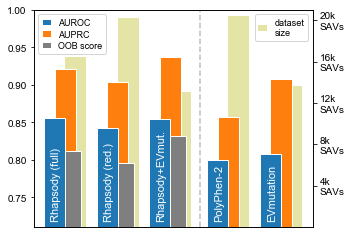

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

data = np.zeros((5,4))
for i, v in enumerate(['full', 'reduced', 'EVmut']):
    for j, x in enumerate(['mean AUROC', 'mean AUPRC', 'mean OOB score', 'dataset size']):
        data[i,j] = RF_training_summaries[v][x]
for i, v in enumerate(['PolyPhen-2', 'EVmutation']):
    for j, x in enumerate(['AUROC', 'AUPRC', 'dataset size']):
        if x=='dataset size': j+=1
        data[i+3,j] = PP2_EVm_metrics[v][x]

# bar plots
X = np.array([0, 1, 2, 3.1, 4.1])

h0 = ax.bar(X + 0.2, data[:,1], color = 'C1', width=.4, edgecolor='w', label='AUPRC')
h1 = ax.bar(X + 0.3, data[:,2], color = 'C7', width=.4, edgecolor='w', label='OOB score')
h2 = ax.bar(X + 0.0, data[:,0], color = 'C0', width=.4, edgecolor='w', label='AUROC')

ax2 = ax.twinx()
hb = ax2.bar(X + 0.4, data[:,3], color = 'C8', width=.4, alpha=0.4, label='dataset\nsize')
ax2.set_zorder(ax.get_zorder()-1)
ax.patch.set_visible(False)

handles = [h2, h0, h1]
ax.legend(handles, [h.get_label() for h in handles], handlelength=1, fontsize=9, 
          loc='upper left', labelspacing=.3)
ax2.legend(handlelength=1, fontsize=9, loc='upper right', labelspacing=.3)

ax.set_ylim((0.71,1))
ax.set_xlim((-.4, 4.9))

ax.set_xticks([])
for i,s in enumerate(['Rhapsody (full)', 'Rhapsody (red.)', 'Rhapsody+EVmut.', 'PolyPhen-2', 'EVmutation']):
    ax.text(X[i]-.065, 0.718, s, color='w', rotation=90, va='bottom', size='11')

ax2.set_ylim((0, 21000))
ax2.set_yticks(range(4000, 21000, 4000))
ax2.set_yticklabels(['4k\nSAVs', '8k\nSAVs', '12k\nSAVs', '16k\nSAVs', '20k\nSAVs'])

ax.axvline(x=2.76, color='gray', ls='--', alpha=.5)

fig.savefig('local/figures/Rhapsody_vs_PP2_EVmut.png', dpi=300)

## Feature importances

We can assess the relative importance of each feature by looking at their weights in the random forest.

In [18]:
abbrv = {
    'ANM_MSF-chain': 'ANM-MSF',
    'ANM_effectiveness-chain': 'ANM-effect.',
    'ANM_sensitivity-chain': 'ANM-sens.',
    'BLOSUM': 'BLOSUM',
    'Delta_PSIC': 'ΔPSIC', 
    'EVmut-DeltaE_epist': 'ΔE EVmutation',
    'SASA': 'SASA',
    'entropy': 'entropy',
    'ranked_MI': 'MI',
    'stiffness-chain': 'ANM-stiffness',
    'wt_PSIC': 'wtPSIC',
    'full': 'Rhapsody (full)',
    'reduced': 'Rhapsody (reduced)',
    'EVmut': 'Rhapsody+EVmutation',
}

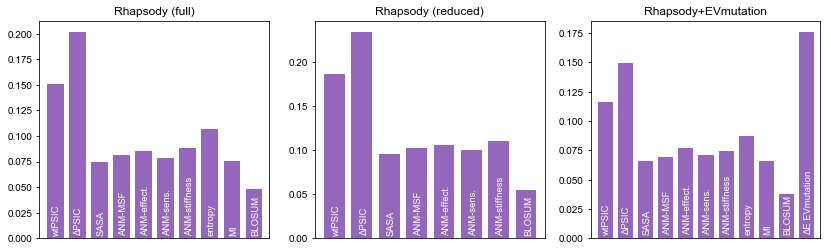

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for i, (version, d) in enumerate(RF_training_summaries.items()):
    
    featset = rd.DEFAULT_FEATSETS[version]
    n = len(featset)
    
    data = d['feat. importance']

    ax = axes[i]
    ax.set_title(abbrv[version])
    
    # bar plots
    X = np.arange(n)
    ax.bar(X, d['feat. importance'], color='C4', width=.8, edgecolor='w')

    ax.set_xlim((-.7, n-0.3))
    
    ax.set_xticks([])
    labels = [abbrv[f] for f in rd.DEFAULT_FEATSETS[version]]
    ax.set_xticklabels(labels, rotation='vertical')
    
    for i,s in enumerate([abbrv[f] for f in featset]):
        ax.text(X[i]+.1, 0.003, s, color='w', rotation=90, ha='center', va='bottom', size='9.5')

fig.savefig('local/figures/feature_importances.png', dpi=300)

## Leave-one-feature-out analysis

An alternative approach to measure a feature's importance is to cross-validate the classifier by leaving out one feature at a time and measure the effect on accuracy.

In [20]:
if os.path.isfile('local/results/LOFO_summaries.pkl'):
    LOFO_summaries = pickle.load(open('local/results/LOFO_summaries.pkl', 'rb'))
    print('A pickle containing precomputed results have been found.')
    print('Please delete it if you wish to run the analysis again.')
else:
    LOGGER.start('local/results/LOFO_analysis.log')
    LOFO_summaries = {}

    for version in ['full', 'reduced', 'EVmut']:
        
        LOFO_summaries[version] = {}
        
        featset = rd.DEFAULT_FEATSETS[version]

        for f_left_out in featset:

            sel = ['SAV_coords', 'true_label'] + [f for f in featset if f != f_left_out]

            LOGGER.info(f'VERSION: {version} - FEATURE LEFT OUT: {f_left_out}')

            # create folder
            folder = f'local/results/LOFO-{version}-{f_left_out}'
            os.mkdir(folder)

            # run cross-validation
            LOFO_summaries[version][f_left_out] = rd.RandomForestCV(ID[sel])

            # move figures into folder
            for file in glob('*png'):
                os.rename(file, os.path.join(folder, file))

            LOGGER.info('')
                    
    # store all cross-validation results into a pickle
    pickle.dump(LOFO_summaries, open('local/results/LOFO_summaries.pkl', 'wb'))

    LOGGER.close('local/results/LOFO_analysis.log')

A pickle containing precomputed results have been found.
Please delete it if you wish to run the analysis again.


In [21]:
abbrv_2 = {
    'ANM_MSF-chain': 'MSF',
    'ANM_effectiveness-chain': 'eff',
    'ANM_sensitivity-chain': 'sens',
    'BLOSUM': 'BLSM',
    'Delta_PSIC': 'ΔPSIC', 
    'EVmut-DeltaE_epist': 'EVm.ΔE',
    'SASA': 'SASA',
    'entropy': 'entropy',
    'ranked_MI': 'MI',
    'stiffness-chain': 'stiff',
    'wt_PSIC': 'wtPSIC',
    'full': 'Rhapsody (full)',
    'reduced': 'Rhapsody (reduced)',
    'EVmut': 'Rhapsody+EVmutation',
}

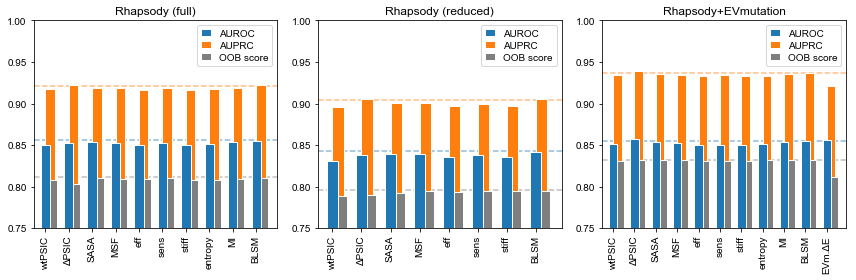

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, (version, d) in enumerate(LOFO_summaries.items()):
    
    featset = rd.DEFAULT_FEATSETS[version]
    n = len(featset)
    
    data = np.zeros((n, 3))
    for j, f in enumerate(featset):
        data[j] = [d[f][x] for x in ('mean AUROC', 'mean AUPRC', 'mean OOB score')]

    ax = axes[i]
    ax.set_title(abbrv_2[version])
    
    for p, c in [('AUROC', 'C0'), ('AUPRC', 'C1'), ('OOB score', 'C7')]:
        ax.axhline(y=RF_training_summaries[version][f'mean {p}'], c=c, ls='--', alpha=.5, zorder=0)
    
    # bar plots
    X = np.arange(n)

    h0 = ax.bar(X + 0.2, data[:,1], color='C1', width=.4, edgecolor='w', label='AUPRC')
    h1 = ax.bar(X + 0.3, data[:,2], color='C7', width=.4, edgecolor='w', label='OOB score')
    h2 = ax.bar(X + 0.0, data[:,0], color='C0', width=.4, edgecolor='w', label='AUROC')

    handles = [h2, h0, h1]
    ax.legend(handles, [h.get_label() for h in handles], handlelength=1, labelspacing=.3)

    ax.set_xlim((-.5, n-0.1))
    ax.set_ylim((0.75,1))

    ax.set_xticks(range(n))
    labels = [abbrv_2[f] for f in featset]
    ax.set_xticklabels(labels, rotation='vertical')

plt.tight_layout()
fig.savefig('local/figures/LOFO.png',  dpi=300)

## Correlation between features

In [23]:
from scipy.stats import spearmanr

featset = rd.DEFAULT_FEATSETS['EVmut']

X = ID[featset]
sel = [~np.isnan(np.sum([x for x in r])) for r in X]
X = X[sel]
X = np.array([[np.float32(x) for x in v] for v in X])

correlations = spearmanr(X)

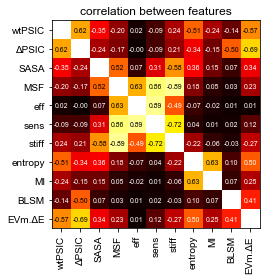

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    
m = correlations[0]

im = ax.imshow(abs(m), cmap='hot', vmin=0, vmax=1)
ax.set_title('correlation between features')

# text annotations
n = m.shape[0]
for i in range(n):
    for j in range(n):
        if i==j: continue
        text = ax.text(j, i, f'{m[i, j]:.2f}', ha="center", va="center", 
                       color="w" if abs(m[i, j])<.5 else "k", fontsize='x-small')

labels = [abbrv_2[f] for f in rd.DEFAULT_FEATSETS['EVmut']]
ax.set_yticks(range(n))
ax.set_yticklabels(labels)
ax.set_xticks(range(n))
ax.set_xticklabels(labels, rotation='vertical')
    
plt.tight_layout()
fig.savefig('local/figures/correlation_btw_features.png', dpi=300)

## Feature distributions

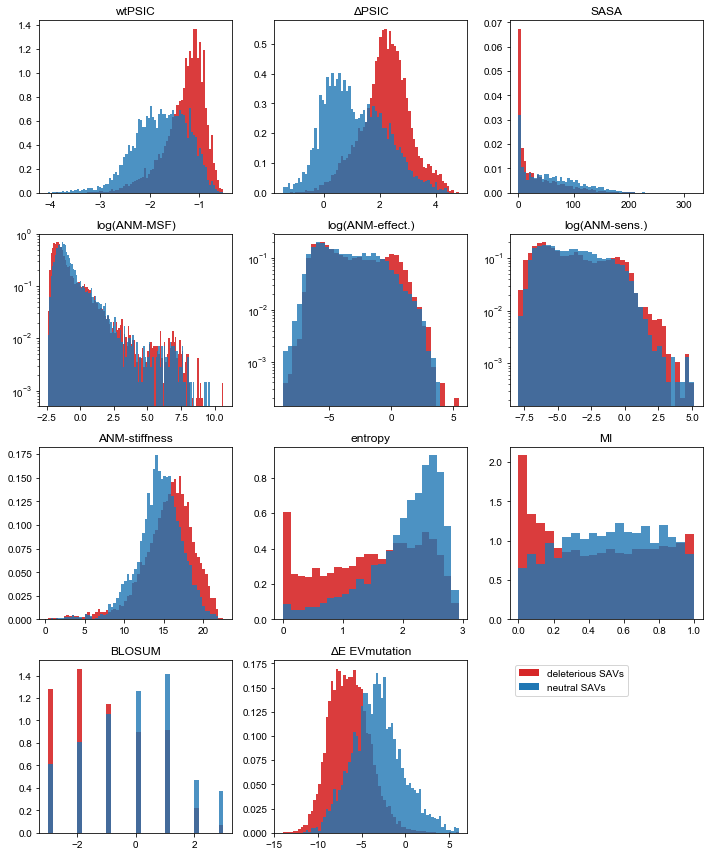

In [25]:
from matplotlib.patches import Patch

fig, axes = plt.subplots(4, 3, figsize=(10, 12))

classes = {
    'del' : ID[ID['true_label']==1],
    'neu' : ID[ID['true_label']==0]
}

for n, feature in enumerate(rd.DEFAULT_FEATSETS['EVmut']):
    
    ax = axes[int(n/3), n%3]
    
    data = {}
    for cl in ('del', 'neu'):
        d = classes[cl][feature]
        data[cl] = d[~np.isnan(d)]

    title = abbrv[feature]

    if feature.startswith('ANM'):
        # use log-log scale
        title = f'log({title})'
        ax.set_yscale('log')
        for k in data:
            data[k] = np.log(data[k])
 
    ax.set_title(title)
    
    n, bins, patches = ax.hist(data['del'], bins='fd', color='C3', alpha=.9, density=True)
    ax.hist(data['neu'], bins=bins, color='C0', alpha=.8, density=True)

axes[3,2].axis('off')
legend_elements = [Patch(facecolor='C3', label='deleterious SAVs'), 
                   Patch(facecolor='C0', label='neutral SAVs')]
axes[3,2].legend(handles=legend_elements, loc='upper left')
        
fig.tight_layout()
fig.savefig('local/figures/feat_distributions.png', dpi=300)

In [26]:
plt.rcParams.update(plt.rcParamsDefault)